<a href="https://colab.research.google.com/github/m1kemp/ecgDiagnosis/blob/main/ColabCode/FullImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os
from pathlib import Path

# 1. Σύνδεση με το Google Drive
drive.mount('/content/drive')

# 2. Ορισμός βασικών διαδρομών (paths)
drive_data_dir = Path("/content/drive/MyDrive/ECGData/data")
local_data_dir = Path("data")
# Διασφάλιση ότι ο τοπικός φάκελος προορισμού υπάρχει
local_data_dir.mkdir(exist_ok=True)

# Λίστα των datasets προς επεξεργασία
zips = [
    "mit-af-database.zip",
    "mit-arrhythmia-database.zip",
    "training2017.zip",
]

def safe_extract(zip_path: Path, dest_dir: Path):
    """Βοηθητική συνάρτηση για ασφαλή αποσυμπίεση αρχείων .zip."""
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(dest_dir)

# 3. Κύρια διαδικασία: Επανάληψη και αποσυμπίεση
for zip_name in zips:
    zip_path = drive_data_dir / zip_name

    # Έλεγχος ύπαρξης αρχείου πριν τη διαδικασία
    if not zip_path.exists():
        print(f"⚠️ Το αρχείο δεν βρέθηκε στο Drive: {zip_path}")
        continue

    print(f"Εκκίνηση αποσυμπίεσης: {zip_path.name} → {local_data_dir}/")
    safe_extract(zip_path, local_data_dir)
    print(f"✅ Ολοκληρώθηκε: {zip_path.name}")

# 4. Επιβεβαίωση περιεχομένων στον τοπικό φάκελο
print("\n📁 Περιεχόμενα του data/:")
for item in local_data_dir.iterdir():
    print(f"  {item.name}")

Mounted at /content/drive
Extracting mit-af-database.zip → data/
✅ Done: mit-af-database.zip
Extracting mit-arrhythmia-database.zip → data/
✅ Done: mit-arrhythmia-database.zip
Extracting training2017.zip → data/
✅ Done: training2017.zip

📁 Contents of data/:
  __MACOSX
  training2017
  mit-bih-arrhythmia-database-1.0.0
  files


In [ ]:
# Εγκατάσταση απαραίτητων βιβλιοθηκών
!pip install wfdb neurokit2 biosppy torch

import os
import numpy as np
import pandas as pd
import wfdb
import scipy.io
import scipy.signal
import neurokit2 as nk
import torch
import gzip
import pickle

# --- Ορισμός Σταθερών Προεπεξεργασίας ---
TARGET_SAMPLING_RATE = 125  # Hz (Στόχος συχνότητας δειγματοληψίας)
MAX_LEN_PHYSIONET = 10 * TARGET_SAMPLING_RATE  # 10 δευτερόλεπτα (Μέγιστο μήκος)

def load_physionet_data(path):
    """Φόρτωση δεδομένων PhysioNet 2017 (αρχεία .mat και REFERENCE.csv)."""
    signals, labels = [], []
    ref_df = pd.read_csv(os.path.join(path, "REFERENCE.csv"), header=None)
    ref_dict = dict(zip(ref_df[0], ref_df[1]))
    # Αντιστοίχιση ετικετών σε ακέραιους
    label_mapping = {"N": 0, "A": 1, "O": 2, "~": 3}

    for file in os.listdir(path):
        if file.endswith(".mat"):
            record_name = file.replace(".mat", "")
            try:
                mat_data = scipy.io.loadmat(os.path.join(path, file))
                signal = mat_data["val"][0]  # Εξαγωγή σήματος ΗΚΓ
                label = ref_dict.get(record_name, None)
                if label and label in label_mapping:
                    signals.append(signal)
                    labels.append(label_mapping[label])
            except Exception as e:
                print(f"Παράλειψη {record_name}: {e}")
    return signals, labels

def downsample_signal(signal, original_fs, target_fs=125):
    """Υποδειγματοληψία (resampling) σήματος ΗΚΓ."""
    if original_fs == target_fs:
        return signal
    num_samples = int(len(signal) * target_fs / original_fs)
    return scipy.signal.resample(signal, num_samples)

def normalize_signal(signal):
    """Κανονικοποίηση Min-Max του σήματος (κλίμακα [0, 1])."""
    signal = np.array(signal, dtype=np.float32)
    signal_min, signal_max = np.min(signal), np.max(signal)
    signal_range = signal_max - signal_min

    # Αποφυγή διαίρεσης με το μηδέν για σήματα με μηδενικό εύρος
    if signal_range < 1e-8:
        return np.zeros_like(signal)

    return (signal - signal_min) / signal_range

def detect_r_peaks(signal, sampling_rate=125):
    """Ανίχνευση R-peaks (κορυφών) με χρήση της βιβλιοθήκης NeuroKit2."""
    try:
        _, r_peaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)
        return np.array(r_peaks["ECG_R_Peaks"])
    except:
        # Χειρισμός σφαλμάτων σε περίπτωση αποτυχίας ανίχνευσης
        return np.array([])

def extract_t_episodes(signal, r_peaks):
    """Εξαγωγή τμημάτων σήματος (χτύπων) με κέντρο τα R-peaks."""
    if len(r_peaks) < 2:
        return []

    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))
    episodes = []

    for r in r_peaks:
        # Ορισμός παραθύρου γύρω από το R-peak
        start = max(0, r - median_rr // 2)
        end = min(len(signal), r + median_rr // 2)
        if end - start > 50:  # Ελάχιστος έλεγχος μήκους
            episodes.append((start, end))
    return episodes

def pad_signal(signal, max_len):
    """Προσθήκη padding (με μηδενικά) για σταθερό μήκος σήματος."""
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        # Περικοπή αν υπερβαίνει το μέγιστο μήκος
        return signal[:max_len]

def preprocess_ecg_dataset(dataset_path):
    """Κύρια συνάρτηση προεπεξεργασίας για το dataset."""
    signals, labels = load_physionet_data(dataset_path)
    # Η αρχική συχνότητα του PhysioNet 2017 είναι 300 Hz
    original_fs = 300
    processed_signals, processed_labels = [], []

    print(f"Επεξεργασία {len(signals)} σημάτων...")

    for i, (signal, label) in enumerate(zip(signals, labels)):
        if i % 100 == 0:
            print(f"Επεξεργασία σήματος {i+1}/{len(signals)}")

        # --- Βήματα Προεπεξεργασίας ---

        # 1. Υποδειγματοληψία
        signal = downsample_signal(signal, original_fs, TARGET_SAMPLING_RATE)

        # 2. Κανονικοποίηση
        signal = normalize_signal(signal)

        # Παράλειψη σημάτων που απέτυχαν στην κανονικοποίηση (π.χ. σταθερή τιμή)
        if np.all(signal == 0):
            continue

        # 3. Ανίχνευση R-peaks
        r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)

        if len(r_peaks) < 2:
            continue

        # 4. Εξαγωγή χτύπων (beats)
        t_eps = extract_t_episodes(signal, r_peaks)

        for start, end in t_eps:
            beat = signal[start:end]
            if len(beat) > 0:  # Διασφάλιση ότι ο χτύπος δεν είναι κενός
                processed_signals.append(pad_signal(beat, MAX_LEN_PHYSIONET))
                processed_labels.append(label)

    return np.array(processed_signals), np.array(processed_labels)

# --- Κύρια Εκτέλεση ---

# Εφαρμογή της προεπεξεργασίας στο σύνολο δεδομένων training2017
physionet_data, physionet_labels = preprocess_ecg_dataset("data/training2017")

# Μετατροπή των numpy arrays σε PyTorch Tensors
X_physionet = torch.tensor(physionet_data, dtype=torch.float32)
y_physionet = torch.tensor(physionet_labels, dtype=torch.long)

# Αποθήκευση των επεξεργασμένων δεδομένων για μελλοντική χρήση
with gzip.open("pretraining_data.pkl.gz", "wb") as f:
    pickle.dump((X_physionet, y_physionet), f)

print(f"Τελικό σχήμα δεδομένων (PhysioNet): {X_physionet.shape}")
print(f"Κατανομή ετικετών: {np.bincount(physionet_labels)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 136.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2

In [ ]:
%%writefile NNModel.py
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Βοηθητική μονάδα: Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    """ Υλοποίηση του Squeeze-and-Excitation (SE) block
        για αναπροσαρμογή βαρύτητας των καναλιών. """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch, channels, _ = x.shape
        se = self.global_avg_pool(x).view(batch, channels)
        se = F.relu(self.fc1(se))
        se = F.sigmoid(self.fc2(se))  # Sigmoid για κλιμάκωση [0, 1]
        se = se.view(batch, channels, 1)
        return x * se  # Εφαρμογή βαρών στα κανάλια

# 2. Βασική δομική μονάδα: Residual Block (με SE)
class ResidualBlock(nn.Module):
    """ Υπολειμματικό μπλοκ (Residual Block) που ενσωματώνει SE
        και συντόμευση (shortcut) για διατήρηση της κλίσης. """
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels)

        # Shortcut connection (1x1 conv) αν αλλάζουν οι διαστάσεις
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()

        self.maxpool = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        residual = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)  # Εφαρμογή SE
        out += residual   # Πρόσθεση υπολειμματικής σύνδεσης
        out = F.relu(out)
        out = self.maxpool(out)  # Υποδειγματοληψία στο τέλος του μπλοκ
        return out

# 3. Κύριο Μοντέλο: Υβριδική Αρχιτεκτονική CNN-BiLSTM
class ECGClassifier(nn.Module):
    """
    Το κύριο μοντέλο ταξινόμησης ΗΚΓ, που συνδυάζει:
    - 1D CNN για εξαγωγή τοπικών χαρακτηριστικών
    - Residual Blocks (με SE) για βαθύτερη εξαγωγή
    - BiLSTM για μοντελοποίηση χρονικών εξαρτήσεων
    - Fully Connected επίπεδα για την τελική ταξινόμηση
    """
    def __init__(self, num_classes=5):
        super(ECGClassifier, self).__init__()

        # --- Επίπεδα Εξαγωγής Χαρακτηριστικών (CNN) ---
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)

        # --- Βαθιά Χαρακτηριστικά (Residual Blocks) ---
        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 96)
        self.resblock3 = ResidualBlock(96, 128)
        self.resblock4 = ResidualBlock(128, 160)

        # --- Επίπεδα Μοντελοποίησης Ακολουθίας (BiLSTM) ---
        self.lstm = nn.LSTM(160, 64, num_layers=2, bidirectional=True,
                            batch_first=True, dropout=0.2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)

        # --- Επίπεδα Ταξινόμησης (Fully Connected) ---
        self.fc1 = nn.Linear(128, 64) # 128 = 64 (fwd) + 64 (bwd)
        self.fc2 = nn.Linear(64, num_classes)

        # Αρχικοποίηση βαρών του μοντέλου
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Αρχικοποίηση βαρών (Kaiming/He initialization)."""
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Είσοδος x: [batch_size, 1, signal_length]

        # 1. Αρχικά CNN
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        # 2. Residual Blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        # x: [batch_size, 160, reduced_length]

        # 3. Αναδιάταξη για BiLSTM
        # Αλλαγή από (Batch, Channels, Length) -> (Batch, Length, Channels)
        x = x.permute(0, 2, 1)

        # 4. BiLSTM
        x, _ = self.lstm(x)
        # Χρήση μόνο της τελευταίας χρονικής κατάστασης (many-to-one)
        x = self.dropout1(x[:, -1, :])

        # 5. FC (Ταξινόμηση)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        # Επιστροφή logits (η CrossEntropyLoss εφαρμόζει το Softmax)
        return x

# Δημιουργία στιγμιοτύπου και εκτύπωση αρχιτεκτονικής
model = ECGClassifier(num_classes=5)
print(model)

Writing NNModel.py


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from NNModel import ECGClassifier  # Εισαγωγή της αρχιτεκτονικής του μοντέλου
import pickle
import gzip
from sklearn.utils.class_weight import compute_class_weight
import numpy as np # Προσθήκη import που έλειπε για το np.unique

# 1. Φόρτωση Προεπεξεργασμένων Δεδομένων
with gzip.open("pretraining_data.pkl.gz", "rb") as f:
    X_train, y_train = pickle.load(f)

print(f"Δεδομένα προ-εκπαίδευσης: {X_train.shape}, Ετικέτες: {len(y_train)}")
print(f"Κατανομή ετικετών: {torch.bincount(y_train)}")

# 2. Ορισμός custom Dataset class για το PyTorch
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Διασφάλιση ότι τα δεδομένα έχουν διάσταση καναλιού (B, C, L)
        self.X = X.unsqueeze(1) if X.dim() == 2 else X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 3. Δημιουργία DataLoader
batch_size = 32  # Μέγεθος παρτίδας
train_dataset = ECGDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# 4. Ορισμός Μοντέλου για Pretraining
# (Κληρονομεί από το ECGClassifier αλλά ορίζει num_classes=4)
class PretrainECGClassifier(ECGClassifier):
    def __init__(self):
        super(PretrainECGClassifier, self).__init__(num_classes=4)

model = PretrainECGClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 5. Ρύθμιση Εκπαίδευσης (Loss, Optimizer)

# Υπολογισμός βαρών (weights) για αντιμετώπιση ανισορροπίας κλάσεων
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(y_train.numpy()),
                                   y=y_train.numpy())
class_weights = torch.FloatTensor(class_weights).to(device)

# Χρήση CrossEntropyLoss με τα υπολογισμένα βάρη
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Scheduler για δυναμική προσαρμογή του learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# 6. Κύριος Βρόχος Εκπαίδευσης (Pretraining Loop)
num_epochs = 10
best_loss = float('inf')

print("--- Έναρξη Προ-εκπαίδευσης ---")
for epoch in range(num_epochs):
    model.train()  # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
    running_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Μηδενισμός των gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()

        # Gradient Clipping (αποφυγή εκρηγνυόμενων κλίσεων)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Ενημέρωση βαρών
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Εποχή {epoch+1}, Παρτίδα {batch_idx}, Απώλεια: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)  # Ενημέρωση του scheduler

    print(f"Εποχή {epoch+1}/{num_epochs}, Μέση Απώλεια: {avg_loss:.4f}")

    # 7. Αποθήκευση του καλύτερου μοντέλου
    if avg_loss < best_loss:
        best_loss = avg_loss
        print(f"Νέα καλύτερη απώλεια. Αποθήκευση μοντέλου...")
        with gzip.open("pretrained_model_best.pth.gz", "wb") as f:
            pickle.dump(model.state_dict(), f)

print("--- Ολοκλήρωση Προ-εκπαίδευσης ---")

ECGClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEBlock(
      (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
    )
    (shortcut): Sequential(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Bat

In [ ]:
# Προεπεξεργασία για το MIT-BIH Dataset
import os
import numpy as np
import torch
import wfdb
import gzip
import pickle
import neurokit2 as nk
from scipy.signal import resample

# --- Ορισμός Σταθερών ---
TARGET_SAMPLING_RATE = 125  # Hz
MAX_LEN_MITBIH = 30 * TARGET_SAMPLING_RATE  # 30 δευτερόλεπτα (μέγιστο μήκος χτύπου)

# Αντιστοίχιση ετικετών AAMI σε 5 κύριες κατηγορίες
label_mapping = {
    # Normal beats (Κανονικοί)
    'N': 0, 'L': 0, 'R': 0, 'B': 0, '.': 0,
    # Supraventricular ectopic beats (Υπερκοιλιακοί)
    'A': 1, 'a': 1, 'J': 1, 'S': 1, 'e': 1, 'j': 1, 'n': 1,
    # Ventricular ectopic beats (Κοιλιακοί)
    'V': 2, 'r': 2, 'E': 2,
    # Fusion beats (Σύτηξης)
    'F': 3,
    # Unknown/Unclassifiable beats (Άγνωστοι/Αταξινόμητοι)
    '/': 4, 'Q': 4, 'f': 4, '?': 4
}

def load_mitbih_record(record_path):
    """Φόρτωση σήματος και annotations από αρχεία MIT-BIH (WFDB)."""
    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
        signal = record.p_signal[:, 0]  # Χρήση μόνο του πρώτου καναλιού (συνήθως MLII)
        return signal, annotation.sample, annotation.symbol
    except Exception as e:
        print(f"Σφάλμα φόρτωσης {record_path}: {e}")
        return None, None, None

def downsample_signal(signal, original_fs=360, target_fs=125):
    """Υποδειγματοληψία σήματος (από 360Hz σε 125Hz)."""
    if original_fs == target_fs:
        return signal
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

def normalize_signal(signal):
    """Κανονικοποίηση Min-Max του σήματος (κλίμακα [0, 1])."""
    signal = np.array(signal, dtype=np.float32)
    signal_min, signal_max = np.min(signal), np.max(signal)
    signal_range = signal_max - signal_min

    if signal_range < 1e-8:  # Αποφυγή διαίρεσης με το μηδέν
        return np.zeros_like(signal)

    return (signal - signal_min) / signal_range

def detect_r_peaks(signal, fs=125):
    """Ανίχνευση R-peaks με χρήση NeuroKit2."""
    try:
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
        return rpeaks["ECG_R_Peaks"]
    except:
        return np.array([])

def extract_t_episodes(signal, r_peaks):
    """Εξαγωγή τμημάτων σήματος (χτύπων) με βάση τα R-peaks."""
    if len(r_peaks) < 2:
        return []

    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))

    # Ορισμός ορίων για το μήκος του παραθύρου
    min_episode_len = max(50, median_rr // 4)
    max_episode_len = min(1000, median_rr * 2)

    episodes = []
    for r in r_peaks:
        half_len = median_rr // 2
        start = max(0, r - half_len)
        end = min(len(signal), r + half_len)

        # Έλεγχος εγκυρότητας μήκους τμήματος
        if (end - start) >= min_episode_len and (end - start) <= max_episode_len:
            episodes.append((start, end))

    return episodes

def assign_labels_to_episodes(episodes, ann_samples, ann_symbols, label_map):
    """Αντιστοίχιση ετικετών (annotations) στα εξαγόμενα τμήματα (episodes)."""
    labels = []
    ann_samples = np.array(ann_samples)

    for start, end in episodes:
        center = (start + end) // 2

        # Εύρεση του πλησιέστερου annotation στο κέντρο του τμήματος
        distances = np.abs(ann_samples - center)
        nearest_idx = np.argmin(distances)

        # Αποδοχή ετικέτας μόνο αν είναι αρκετά κοντά (π.χ. < 1 δευτ.)
        if distances[nearest_idx] <= TARGET_SAMPLING_RATE:  # 125 δείγματα = 1s
            label = ann_symbols[nearest_idx]
            if label in label_map:
                labels.append(label_map[label])
            else:
                labels.append(4)  # Άγνωστη κλάση
        else:
            labels.append(None)  # Παράλειψη τμήματος (καμία ετικέτα κοντά)

    return labels

def pad_signal(signal, max_len):
    """Προσθήκη padding (με μηδενικά) ή περικοπή για σταθερό μήκος."""
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

def preprocess_mitbih_dataset(dataset_dir):
    """Κύρια συνάρτηση προεπεξεργασίας για το MIT-BIH dataset."""
    all_beats, all_labels = [], []
    processed_files = 0
    total_files = len([f for f in os.listdir(dataset_dir) if f.endswith('.dat')])

    print(f"Επεξεργασία {total_files} αρχείων MIT-BIH...")

    for file in sorted(os.listdir(dataset_dir)):
        if file.endswith('.dat'):
            record_name = file.replace('.dat', '')
            record_path = os.path.join(dataset_dir, record_name)

            print(f"Επεξεργασία {record_name} ({processed_files+1}/{total_files})")

            # 1. Φόρτωση
            signal, ann_samples, ann_symbols = load_mitbih_record(record_path)
            if signal is None:
                continue

            try:
                # 2. Υποδειγματοληψία (Signal & Annotations)
                signal_down = downsample_signal(signal)
                ann_samples_down = (np.array(ann_samples) * (TARGET_SAMPLING_RATE / 360)).astype(int)

                # 3. Κανονικοποίηση
                signal_norm = normalize_signal(signal_down)

                if np.all(signal_norm == 0):
                    print(f"  Παράλειψη {record_name}: απέτυχε η κανονικοποίηση")
                    continue

                # 4. Ανίχνευση R-peaks (από το επεξεργασμένο σήμα)
                r_peaks = detect_r_peaks(signal_norm, TARGET_SAMPLING_RATE)

                if len(r_peaks) < 2:
                    print(f"  Παράλειψη {record_name}: ανεπαρκή R-peaks")
                    continue

                # 5. Εξαγωγή Τμημάτων (Χτύπων)
                t_episodes = extract_t_episodes(signal_norm, r_peaks)

                # 6. Αντιστοίχιση Ετικετών (με τα downsampled annotations)
                labels = assign_labels_to_episodes(t_episodes, ann_samples_down, ann_symbols, label_mapping)

                # 7. Συλλογή έγκυρων χτύπων
                valid_episodes = 0
                for (start, end), label in zip(t_episodes, labels):
                    if label is not None:
                        beat = signal_norm[start:end]
                        if len(beat) > 0:
                            padded = pad_signal(beat, MAX_LEN_MITBIH)
                            all_beats.append(padded)
                            all_labels.append(label)
                            valid_episodes += 1

                print(f"  Εξαγωγή {valid_episodes} έγκυρων χτύπων από {record_name}")
                processed_files += 1

            except Exception as e:
                print(f"  Σφάλμα κατά την επεξεργασία {record_name}: {e}")
                continue

    print(f"\nΟλοκληρώθηκε η επεξεργασία {processed_files}/{total_files} αρχείων")
    print(f"Συνολικοί χτύποι που εξήχθησαν: {len(all_beats)}")

    return np.array(all_beats), np.array(all_labels)

# --- Κύρια Εκτέλεση ---

# Εφαρμογή προεπεξεργασίας
mitbih_signals, mitbih_labels = preprocess_mitbih_dataset("data/mit-bih-arrhythmia-database-1.0.0")

# Μετατροπή σε PyTorch tensors
X_mitbih = torch.tensor(mitbih_signals, dtype=torch.float32)
y_mitbih = torch.tensor(mitbih_labels, dtype=torch.long)

# Αποθήκευση επεξεργασμένων δεδομένων
with gzip.open("mitbih_beats.pkl.gz", "wb") as f:
    pickle.dump((X_mitbih, y_mitbih), f)

print(f"\nΤελικό σχήμα (MIT-BIH Beats): {X_mitbih.shape}")

# Εμφάνιση κατανομής κλάσεων
print("\nΚατανομή Ετικετών:")
label_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
unique_labels, counts = np.unique(mitbih_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    if label < len(label_names):
        print(f"  {label_names[label]} (Κλάση {label}): {count} χτύποι ({count/len(mitbih_labels)*100:.1f}%)")

Processing 48 MIT-BIH files...
Processing 100 (1/48)
  Extracted 2270 valid episodes from 100
Processing 101 (2/48)
  Extracted 1868 valid episodes from 101
Processing 102 (3/48)
  Extracted 2187 valid episodes from 102
Processing 103 (4/48)
  Extracted 2084 valid episodes from 103
Processing 104 (5/48)
  Extracted 2203 valid episodes from 104
Processing 105 (6/48)
  Extracted 2570 valid episodes from 105
Processing 106 (7/48)
  Extracted 2032 valid episodes from 106
Processing 107 (8/48)
  Extracted 2136 valid episodes from 107
Processing 108 (9/48)
  Extracted 1770 valid episodes from 108
Processing 109 (10/48)
  Extracted 2531 valid episodes from 109
Processing 111 (11/48)
  Extracted 2124 valid episodes from 111
Processing 112 (12/48)
  Extracted 2539 valid episodes from 112
Processing 113 (13/48)
  Extracted 1826 valid episodes from 113
Processing 114 (14/48)
  Extracted 1882 valid episodes from 114
Processing 115 (15/48)
  Extracted 1953 valid episodes from 115
Processing 116 (16

In [ ]:
from google.colab import drive
import os

# 1. Σύνδεση με το Google Drive
drive.mount('/content/drive')

# 2. Ορισμός διαδρομών και αρχείων
# Βασικός φάκελος στο Drive όπου είναι αποθηκευμένα τα επεξεργασμένα αρχεία
drive_base = "/content/drive/MyDrive/ECGData"
# Λίστα των αρχείων προς μεταφορά στον τοπικό χώρο του Colab
files_to_copy = [
    "pretrained_model_best.pth.gz", # Τα βάρη του προ-εκπαιδευμένου μοντέλου
    "pretraining_data.pkl.gz",      # Τα δεδομένα προ-εκπαίδευσης (PhysioNet)
    "mitbih_beats.pkl.gz"           # Τα επεξεργασμένα δεδομένα (MIT-BIH)
]

# 3. Αντιγραφή αρχείων από το Drive στο Colab
print("--- Έναρξη αντιγραφής αρχείων από το Drive ---")
for file_name in files_to_copy:
    source_path = f"{drive_base}/{file_name}"

    # Έλεγχος ύπαρξης του αρχείου στο Drive πριν την αντιγραφή
    if os.path.exists(source_path):
        # Χρήση !cp για εκτέλεση εντολής shell (αντιγραφή)
        !cp "{source_path}" /content/
        print(f"✅ Ολοκληρώθηκε: {file_name}")
    else:
        print(f"⚠️ 	Προσοχή: Το αρχείο δεν βρέθηκε στο Drive: {source_path}")

# 4. Επιβεβαίωση ύπαρξης αρχείων στον τοπικό χώρο (/content/)
print("\n📁 Έλεγχος αρχείων στον τοπικό φάκελο /content/:")
for file_name in files_to_copy:
    local_path = f"/content/{file_name}"
    if os.path.exists(local_path):
        size_mb = os.path.getsize(local_path) / (1024*1024)
        print(f"  ✅ {file_name} ({size_mb:.1f} MB)")
    else:
        print(f"  ❌ {file_name} - Η αντιγραφή απέτυχε!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚠️  File not found: /content/drive/MyDrive/ECGData/pretrained_model_best.pth.gz
⚠️  File not found: /content/drive/MyDrive/ECGData/pretraining_data.pkl.gz
⚠️  File not found: /content/drive/MyDrive/ECGData/mitbih_beats.pkl.gz

📁 Files in /content/:
  ✅ pretrained_model_best.pth.gz (14.1 MB)
  ✅ pretraining_data.pkl.gz (112.4 MB)
  ✅ mitbih_beats.pkl.gz (37.1 MB)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from NNModel import ECGClassifier # Εισαγωγή της αρχιτεκτονικής
import matplotlib.pyplot as plt

# --------------------
# 1. Φόρτωση και Ανάλυση Δεδομένων (MIT-BIH)
# --------------------
print("Φόρτωση δεδομένων MIT-BIH...")
with gzip.open("mitbih_beats.pkl.gz", "rb") as f:
    X_mit, y_mit = pickle.load(f)

print(f"Data shape: {X_mit.shape}")
print(f"Labels shape: {y_mit.shape}")

# Ανάλυση κατανομής κλάσεων
unique_labels, counts = np.unique(y_mit, return_counts=True)
print(f"\nΚατανομή κλάσεων:")
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']
for label, count in zip(unique_labels, counts):
    percentage = (count / len(y_mit)) * 100
    print(f"  Κλάση {label} ({class_names[label]}): {count} δείγματα ({percentage:.2f}%)")

# Διαχωρισμός δεδομένων: Train-Validation-Test (60/20/20)
# Χρήση 'stratify' για διατήρηση της αναλογίας κλάσεων στα σύνολα
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_mit, y_mit, test_size=0.2, random_state=42, stratify=y_mit
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val  # 0.25 του 0.8 = 0.2
)

print(f"\nΜεγέθη συνόλων δεδομένων:")
print(f"  Train: {X_train.shape[0]} δείγματα")
print(f"  Validation: {X_val.shape[0]} δείγματα")
print(f"  Test: {X_test.shape[0]} δείγματα")

# --------------------
# 2. Custom Dataset Class (με Data Augmentation)
# --------------------
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X.unsqueeze(1) if X.dim() == 2 else X  # Προσθήκη διάστασης καναλιού (B, C, L)
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone()
        y = self.y[idx]

        # Εφαρμογή απλών τεχνικών αύξησης δεδομένων (μόνο στο training set)
        if self.augment:
            # Προσθήκη θορύβου (noise)
            if np.random.rand() < 0.3:
                noise = torch.randn_like(x) * 0.01
                x = x + noise

            # Μικρή χρονική μετατόπιση (time shift)
            if np.random.rand() < 0.3:
                shift = np.random.randint(-10, 11)
                x = torch.roll(x, shift, dims=-1)

        return x, y

# --------------------
# 3. Δημιουργία DataLoaders
# --------------------
batch_size = 128
train_dataset = ECGDataset(X_train, y_train, augment=True)
val_dataset = ECGDataset(X_val, y_val, augment=False)
test_dataset = ECGDataset(X_test, y_test, augment=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                       shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# --------------------
# 4. Αρχικοποίηση Μοντέλου (Transfer Learning)
# --------------------
print("\nΑρχικοποίηση μοντέλου...")
model = ECGClassifier(num_classes=5) # 5 κλάσεις για το MIT-BIH
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Χρήση συσκευής: {device}")
model.to(device)

# Φόρτωση προ-εκπαιδευμένων βαρών (από το PhysioNet pretraining)
try:
    with gzip.open("pretrained_model_best.pth.gz", "rb") as f:
        pretrained_dict = pickle.load(f)

    # Φιλτράρισμα: Αφαίρεση του τελικού επιπέδου ταξινόμησης (fc2)
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                       if not k.startswith('fc2')}

    # Φόρτωση των βαρών (strict=False για να αγνοηθεί το fc2 που λείπει)
    missing_keys, unexpected_keys = model.load_state_dict(pretrained_dict, strict=False)
    print(f"Φορτώθηκαν προ-εκπαιδευμένα βάρη. Missing: {len(missing_keys)}, Unexpected: {len(unexpected_keys)}")

    # Επανα-αρχικοποίηση του τελικού (FC) επιπέδου για 5 κλάσεις
    model.fc2 = nn.Linear(model.fc2.in_features, 5).to(device)
    nn.init.kaiming_normal_(model.fc2.weight)
    nn.init.constant_(model.fc2.bias, 0)

except Exception as e:
    print(f"Προειδοποίηση: Αδυναμία φόρτωσης προ-εκπαιδευμένων βαρών: {e}")
    print("Εκπαίδευση από την αρχή (scratch)...")

# --------------------
# 5. Ρυθμίσεις Εκπαίδευσης (Loss, Optimizer, Weights)
# --------------------
# Υπολογισμός βαρών (class weights) για το ανισόρροπο dataset
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(y_train.numpy()),
                                   y=y_train.numpy())
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

# Χρήση βαρών στη συνάρτηση απώλειας (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# Scheduler για δυναμική προσαρμογή του learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5,
                                               factor=0.5)

# --------------------
# 6. Κύριος Βρόχος Εκπαίδευσης (Fine-Tuning Loop)
# --------------------
num_epochs = 50
best_val_acc = 0.0
patience_counter = 0
patience = 10 # Υπομονή για το Early Stopping

train_losses, val_losses, val_accs = [], [], [] # Για αποθήκευση ιστορικού

print(f"\nΈναρξη εκπαίδευσης (fine-tuning) για {num_epochs} κύκλους...")
for epoch in range(num_epochs):

    # --- Φάση Εκπαίδευσης (Training) ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping για σταθερότητα
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        if batch_idx % 50 == 0:
            # --- ΕΔΩ ΕΓΙΝΕ Η ΑΛΛΑΓΗ ---
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, "
                  f"Loss: {loss.item():.4f}, Acc: {100*correct/total:.2f}%")

    train_acc = 100.0 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Φάση Επικύρωσης (Validation) ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad(): # Απενεργοποίηση υπολογισμού κλίσεων
        for X_val, y_val_batch in val_loader:
            X_val, y_val_batch = X_val.to(device), y_val_batch.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, y_val_batch).item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += y_val_batch.size(0)
            val_correct += (val_predicted == y_val_batch).sum().item()

    val_acc = 100.0 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    # Ενημέρωση του scheduler
    scheduler.step(avg_val_loss)

    # --- ΕΔΩ ΕΓΙΝΕ Η ΑΛΛΑΓΗ ---
    print(f"Κύκλος {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

    # --- Έλεγχος Early Stopping & Αποθήκευση Καλύτερου Μοντέλου ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 # Μηδενισμός υπομονής

        # Αποθήκευση του μοντέλου με την καλύτερη επίδοση
        torch.save(model.state_dict(), "best_model.pth")
        print(f"  💾 Αποθηκεύτηκε νέο καλύτερο μοντέλο! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1

    # Έλεγχος για τερματισμό (Early Stopping)
    if patience_counter >= patience:
        # --- ΕΔΩ ΕΓΙΝΕ Η ΑΛΛΑΓΗ ---
        print(f"Ενεργοποίηση Early Stopping μετά από {epoch+1} κύκλους")
        break

# --------------------
# 7. Φόρτωση Καλύτερου Μοντέλου & Αποθήκευση στο Drive
# --------------------

# Φόρτωση του καλύτερου μοντέλου που αποθηκεύτηκε κατά τη διάρκεια του training
model.load_state_dict(torch.load("best_model.pth"))
print(f"\nΟλοκληρώθηκε η εκπαίδευση! Καλύτερη ακρίβεια (validation): {best_val_acc:.2f}%")

# Αποθήκευση του τελικού (καλύτερου) μοντέλου στο Google Drive
from google.colab import drive
drive.mount('/content/drive')
final_model_path = "/content/drive/MyDrive/ColabData/ECG/ecg_mitbih_finetuned_improved.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Το τελικό (καλύτερο) μοντέλο αποθηκεύτηκε στο Drive: {final_model_path}")

Loading MIT-BIH data...
Data shape: torch.Size([109067, 3750])
Labels shape: torch.Size([109067])

Class distribution:
  Class 0 (Normal): 89860 samples (82.39%)
  Class 1 (Supraventricular): 2952 samples (2.71%)
  Class 2 (Ventricular): 7003 samples (6.42%)
  Class 3 (Fusion): 799 samples (0.73%)
  Class 4 (Unknown): 8453 samples (7.75%)

Data splits:
  Train: 65439 samples
  Validation: 21814 samples
  Test: 21814 samples

Initializing model...
Using device: cuda
Loaded pretrained weights. Missing: 2, Unexpected: 0
Class weights: tensor([ 0.2427,  7.3859,  3.1147, 27.3232,  2.5809], device='cuda:0')

Starting training for 50 epochs...
Epoch 1, Batch 0/511, Loss: 2.5241, Acc: 9.38%
Epoch 1, Batch 50/511, Loss: 1.5452, Acc: 35.48%
Epoch 1, Batch 100/511, Loss: 1.4639, Acc: 31.95%
Epoch 1, Batch 150/511, Loss: 1.2908, Acc: 31.93%
Epoch 1, Batch 200/511, Loss: 1.1321, Acc: 34.92%
Epoch 1, Batch 250/511, Loss: 1.4973, Acc: 38.02%
Epoch 1, Batch 300/511, Loss: 0.8495, Acc: 40.85%
Epoch 1, 

RuntimeError: Parent directory /content/drive/MyDrive/ColabData/ECG does not exist.

In [ ]:
# --- 1. Φάση Αξιολόγησης (Test Set) ---
model.eval() # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
all_preds, all_probs, all_labels = [], [], []

print("Αξιολόγηση μοντέλου στο σύνολο ελέγχου (test set)...")
with torch.no_grad(): # Απενεργοποίηση υπολογισμού κλίσεων (gradients)
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)

        # Μετατροπή εξόδου σε πιθανότητες (διαχείριση logits vs log_softmax)
        if hasattr(model, 'forward') and 'log_softmax' in str(model.forward):
            probs = torch.exp(outputs) # Μετατροπή log-πιθανοτήτων σε πιθανότητες
        else:
            probs = F.softmax(outputs, dim=1) # Εφαρμογή Softmax

        preds = torch.argmax(probs, dim=1)

        # Συλλογή αποτελεσμάτων
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Μετατροπή λιστών σε numpy arrays για χρήση με sklearn
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Ορισμός ονομάτων κλάσεων για τις αναφορές
class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']

# --- 2. Αναλυτικά Αποτελέσματα Αξιολόγησης ---
print("\n" + "="*50)
print("ΣΥΝΟΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ ΑΞΙΟΛΟΓΗΣΗΣ")
print("="*50)

# Συνολικές μετρικές (Overall & Weighted)
print(f"\nΣυνολική Ακρίβεια (Overall Accuracy): {accuracy_score(all_labels, all_preds):.4f}")
print(f"Σταθμισμένη Ακρίβεια (Weighted Precision): {precision_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"Σταθμισμένη Ανάκληση (Weighted Recall): {recall_score(all_labels, all_preds, average='weighted'):.4f}")
print(f"Σταθμισμένο F1-Score (Weighted F1-Score): {f1_score(all_labels, all_preds, average='weighted'):.4f}")

# Μετρικές Macro-Average (κατάλληλες για ανισόρροπα δεδομένα)
print(f"\nΜετρικές Macro-averaged:")
print(f"Macro Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(all_labels, all_preds, average='macro'):.4f}")

# Πλήρης Αναφορά Ταξινόμησης (Classification Report)
print(f"\nΑναλυτική Αναφορά Ταξινόμησης (Classification Report):")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Υπολογισμός ROC-AUC (One-vs-Rest για multi-class)
try:
    present_classes = np.unique(all_labels)
    if len(present_classes) == 5:
        # Binarization των ετικετών για 'ovr'
        y_true_bin = np.eye(5)[all_labels]
        auc_score = roc_auc_score(y_true_bin, all_probs, multi_class='ovr')
        print(f"\nMulticlass ROC-AUC Score (OvR): {auc_score:.4f}")

        print(f"\nAUC scores ανά κλάση:")
        for i, class_name in enumerate(class_names):
            if i in present_classes:
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
                class_auc = auc(fpr, tpr)
                print(f"  {class_name}: {class_auc:.4f}")
    else:
        print(f"Σημείωση: Μόνο {len(present_classes)} κλάσεις παρούσες στο test set, παράλειψη ROC-AUC")

except Exception as e:
    print(f"Σφάλμα υπολογισμού ROC-AUC: {e}")

# Αναλυτικές μετρικές ανά κλάση (Precision, Recall, F1)
print(f"\nΑπόδοση ανά Κλάση:")
for i, class_name in enumerate(class_names):
    if i in present_classes:
        class_precision = precision_score(all_labels, all_preds, labels=[i], average=None)
        class_recall = recall_score(all_labels, all_preds, labels=[i], average=None)
        class_f1 = f1_score(all_labels, all_preds, labels=[i], average=None)
        class_support = np.sum(all_labels == i)

        if len(class_precision) > 0:
            print(f"  {class_name:15} - Precision: {class_precision[0]:.4f}, "
                  f"Recall: {class_recall[0]:.4f}, F1: {class_f1[0]:.4f}, "
                  f"Support: {class_support}")

Evaluating model on test set...

COMPREHENSIVE EVALUATION RESULTS

Overall Accuracy: 0.9887
Weighted Precision: 0.9891
Weighted Recall: 0.9887
Weighted F1-Score: 0.9888

Macro-averaged Metrics:
Macro Precision: 0.9205
Macro Recall: 0.9590
Macro F1-Score: 0.9384

Detailed Classification Report:
                  precision    recall  f1-score   support

          Normal     0.9965    0.9921    0.9943     17972
Supraventricular     0.8815    0.9203    0.9005       590
     Ventricular     0.9730    0.9786    0.9758      1401
          Fusion     0.7684    0.9125    0.8343       160
         Unknown     0.9830    0.9917    0.9873      1691

        accuracy                         0.9887     21814
       macro avg     0.9205    0.9590    0.9384     21814
    weighted avg     0.9891    0.9887    0.9888     21814


Multiclass ROC-AUC Score: 0.9968

Per-class AUC scores:
  Normal: 0.9985
  Supraventricular: 0.9933
  Ventricular: 0.9996
  Fusion: 0.9933
  Unknown: 0.9993

Per-class Performance

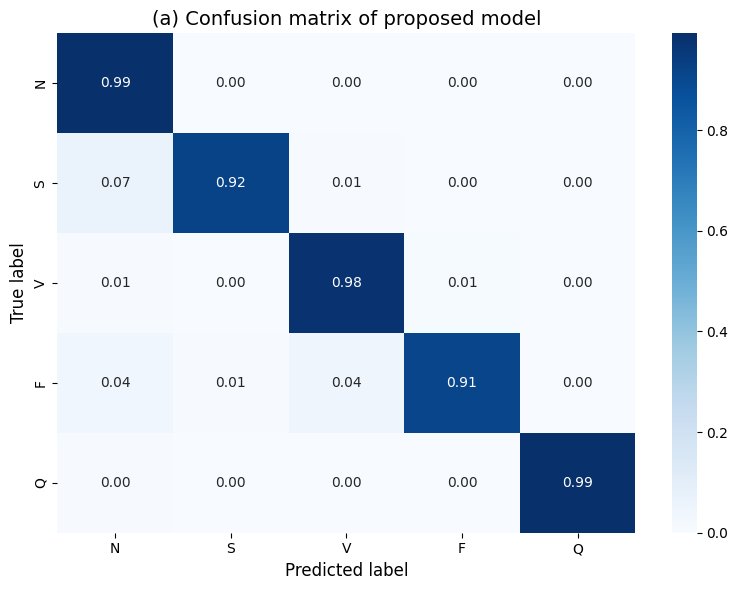

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Οπτικοποίηση:Confusion Matrix ---

# 1. Ορισμός ετικετών (όπως χρησιμοποιούνται στο MIT-BIH)
class_names = ['N', 'S', 'V', 'F', 'Q'] # N=Normal, S=Supraventricular, V=Ventricular, F=Fusion, Q=Unknown

# 2. Υπολογισμός του πίνακα σύγχυσης
# all_labels = Πραγματικές ετικέτες, all_preds = Προβλέψεις μοντέλου
cm = confusion_matrix(all_labels, all_preds)

# 3. Κανονικοποίηση του πίνακα (τιμές από 0 έως 1)
# Διαιρούμε κάθε κελί με το άθροισμα της γραμμής του (true label)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 4. Σχεδίαση του πίνακα (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=True)

plt.title("(a)Confusion Matrix (Κανονικοποιημένος)", fontsize=14)
plt.xlabel("Προβλεπόμενη Ετικέτα (Predicted)", fontsize=12)
plt.ylabel("Πραγματική Ετικέτα (True)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

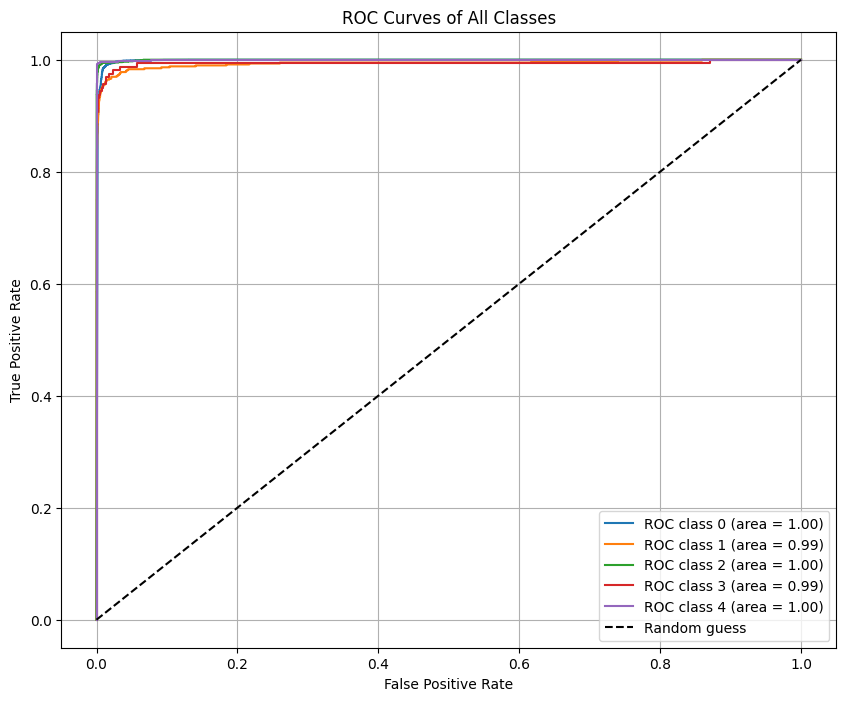

In [ ]:
# --- Οπτικοποίηση: Καμπύλες ROC (One-vs-Rest) ---

# 1. Δημιουργία καμβά σχεδίασης
plt.figure(figsize=(10, 8))

# 2. Επανάληψη για κάθε κλάση (0 έως 4)
for i in range(5):
    # Υπολογισμός FPR, TPR (από τα binarized labels και τις πιθανότητες)
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    # Υπολογισμός εμβαδού κάτω από την καμπύλη (AUC)
    roc_auc = auc(fpr, tpr)
    # Σχεδίαση της καμπύλης της συγκεκριμένης κλάσης
    plt.plot(fpr, tpr, label=f"ROC Κλάσης {i} (AUC = {roc_auc:.2f})")

# 3. Σχεδίαση γραμμής αναφοράς (τυχαία ταξινόμηση)
plt.plot([0, 1], [0, 1], 'k--', label='Τυχαία Πρόβλεψη')

# 4. Ρυθμίσεις γραφήματος (τίτλοι, άξονες, υπόμνημα)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Καμπύλες Λειτουργικού Χαρακτηριστικού (ROC) - OvR")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Προεπεξεργασία δεδομένων MIT-AF (3 κλάσεις)
import os
import wfdb
import numpy as np
import torch
import gzip
import pickle
import neurokit2 as nk
from scipy.signal import resample

# --- Ορισμός Σταθερών ---
TARGET_SAMPLING_RATE = 125 # Στόχος συχνότητας δειγματοληψίας (Hz)
MAX_LEN_AF = 30 * TARGET_SAMPLING_RATE  # Μέγιστο μήκος τμήματος (30 δευτ.)

# Αντιστοίχιση 3 κατηγοριών (αγνοείται η κλάση 'J')
label_mapping = {
    "N": 0,
    "AFIB": 1,
    "AFL": 2
    # Η κλάση J και άλλες αγνοούνται
}

def downsample_signal(signal, original_fs=250, target_fs=125):
    """Βοηθητική συνάρτηση: Υποδειγματοληψία (από 250Hz σε 125Hz)."""
    if original_fs == target_fs:
        return signal
    num_samples = int(len(signal) * target_fs / original_fs)
    return resample(signal, num_samples)

def normalize_signal(signal):
    """Βοηθητική συνάρτηση: Κανονικοποίηση Min-Max [0, 1]."""
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-8)

def detect_r_peaks(signal, fs=125):
    """Βοηθητική συνάρτηση: Ανίχνευση R-peaks (με NeuroKit2)."""
    _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
    return rpeaks["ECG_R_Peaks"]

def extract_t_episodes(signal, r_peaks):
    """Βοηθητική συνάρτηση: Εξαγωγή τμημάτων (χτύπων) γύρω από τα R-peaks."""
    if len(r_peaks) < 2:
        return []
    rr_intervals = np.diff(r_peaks)
    median_rr = int(np.median(rr_intervals))
    episodes = []
    for r in r_peaks:
        start = max(0, r - median_rr // 2)
        end = min(len(signal), r + median_rr // 2)
        episodes.append((start, end))
    return episodes

def build_samplewise_labels(record_len, ann_samples, ann_symbols):
    """Δημιουργία 'πυκνών' ετικετών (μία ετικέτα ανά δείγμα σήματος)."""
    labels = np.array([""] * record_len, dtype=object)
    ann_samples = np.array(ann_samples)
    ann_symbols = np.array(ann_symbols, dtype=object)
    if len(ann_samples) == 0:
        return labels
    order = np.argsort(ann_samples)
    ann_samples = ann_samples[order]
    ann_symbols = ann_symbols[order]
    for i in range(len(ann_samples)):
        start = ann_samples[i]
        end = ann_samples[i+1] if i+1 < len(ann_samples) else record_len
        if start < 0: start = 0
        if end > record_len: end = record_len
        labels[start:end] = ann_symbols[i]
    return labels

def get_label(sym):
    """Επιστρέφει την αριθμητική ετικέτα (0, 1, 2) ή None αν δεν ανήκει στις 3 κλάσεις."""
    if sym is None or str(sym).strip() == "":
        return None
    s = str(sym).strip().upper()
    s = s.replace("(", "")
    # Επιστροφή ετικέτας μόνο αν είναι στο 3-class mapping
    if s in label_mapping:
        return label_mapping[s]
    else:
        return None  # Αγνοεί 'J' και άγνωστες κλάσεις

def pad_signal(signal, max_len):
    """Βοηθητική συνάρτηση: Padding/Truncating για σταθερό μήκος."""
    if len(signal) < max_len:
        return np.pad(signal, (0, max_len - len(signal)), 'constant')
    else:
        return signal[:max_len]

def preprocess_afdb_beats(dataset_dir):
    """Κύρια συνάρτηση: Επεξεργασία του AFDB dataset (3 κλάσεις)."""
    all_beats, all_labels = [], []
    ignored_count = 0
    processed_count = 0
    j_class_ignored = 0  # Μέτρηση χτύπων 'J' που αγνοήθηκαν

    for file in os.listdir(dataset_dir):
        if file.endswith('.dat'):
            recname = os.path.join(dataset_dir, file.replace('.dat', ''))
            try:
                rec = wfdb.rdrecord(recname)
                signal = rec.p_signal[:, 0].astype(np.float32)
                fs = rec.fs

                # 1. Υποδειγματοληψία σήματος
                signal = downsample_signal(signal, original_fs=fs, target_fs=TARGET_SAMPLING_RATE)

                # 2. Φόρτωση annotations (και υποδειγματοληψία των θέσεων)
                ann = wfdb.rdann(recname, 'atr')
                ann_samples = (np.array(ann.sample) * (TARGET_SAMPLING_RATE / fs)).astype(int)
                ann_symbols = ann.aux_note if hasattr(ann, "aux_note") else ann.symbol

                # 3. Δημιουργία 'πυκνών' ετικετών (ανά δείγμα)
                sample_labels = build_samplewise_labels(len(signal), ann_samples, ann_symbols)

                # 4. Κανονικοποίηση
                signal = normalize_signal(signal)

                # 5. Ανίχνευση R-peaks
                r_peaks = detect_r_peaks(signal, TARGET_SAMPLING_RATE)

                # 6. Εξαγωγή τμημάτων χτύπων
                t_episodes = extract_t_episodes(signal, r_peaks)

                for (start, end) in t_episodes:
                    # 7. Έλεγχος ετικέτας στο κέντρο του χτύπου
                    center = (start + end) // 2
                    original_sym = str(sample_labels[center]).strip().upper().replace("(", "")
                    label = get_label(sample_labels[center])

                    # Αποθήκευση μόνο εάν η ετικέτα είναι μία από τις {N, AFIB, AFL}
                    if label is not None:
                        beat = signal[start:end]
                        padded = pad_signal(beat, MAX_LEN_AF)
                        all_beats.append(padded)
                        all_labels.append(label)
                        processed_count += 1
                    else:
                        # Καταμέτρηση αγνοημένων χτύπων (π.χ. 'J')
                        if original_sym == "J":
                            j_class_ignored += 1
                        ignored_count += 1
            except Exception as e:
                print(f"Παράλειψη {recname}, σφάλμα: {e}")

    print(f"Επεξεργάστηκαν: {processed_count} χτύποι")
    print(f"Αγνοήθηκαν: {ignored_count} χτύποι (εκ των οποίων {j_class_ignored} ήταν κλάσης 'J')")
    return np.array(all_beats), np.array(all_labels)

# --- Κύρια Εκτέλεση ---

# Εφαρμογή της προεπεξεργασίας
afdb_beats, afdb_labels = preprocess_afdb_beats("data/files")

# Μετατροπή σε PyTorch Tensors
X_afdb = torch.tensor(afdb_beats, dtype=torch.float32)
y_afdb = torch.tensor(afdb_labels, dtype=torch.long)

# Αποθήκευση (με νέο όνομα για τις 3 κατηγορίες)
with gzip.open("afdb_beats_3cat.pkl.gz", "wb") as f:
    pickle.dump((X_afdb, y_afdb), f)

# Εκτύπωση αποτελεσμάτων
print(f"AFDB Beats Shape: {X_afdb.shape}")
print(f"Unique Labels: {np.unique(afdb_labels, return_counts=True)}")
print("Class mapping: 0=AFIB, 1=AFL, 2=N")

AFDB Beats Shape: torch.Size([1146813, 3750])
Unique Labels: (array([0, 1, 2, 3, 4]), array([513691,  12385,    304, 620429,      4]))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle, gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from NNModel import ECGClassifier # Εισαγωγή αρχιτεκτονικής
import matplotlib.pyplot as plt

# Ορισμός συσκευής (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Χρήση συσκευής: {device}")

# --------------------
# 1. Φόρτωση Δεδομένων (AFDB - 3 Κλάσεις)
# --------------------
print("Φόρτωση δεδομένων AFDB (3 κλάσεις)...")
with gzip.open("afdb_beats_3cat.pkl.gz", "rb") as f:
    X_afdb, y_afdb = pickle.load(f)

print(f"Data shape: {X_afdb.shape}")
print(f"Labels shape: {y_afdb.shape}")

# Έλεγχος κατανομής κλάσεων
unique_labels, counts = np.unique(y_afdb, return_counts=True)
class_names = ['N','AFIB','AFL']  # Ενημέρωση για 3 κλάσεις
print("\nΚατανομή κλάσεων:")
for label, count in zip(unique_labels, counts):
    pct = (count / len(y_afdb)) * 100
    print(f"  Κλάση {label} ({class_names[label]}): {count} δείγματα ({pct:.2f}%)")

# Διαχωρισμός δεδομένων (60-20-20) με stratify
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_afdb, y_afdb, test_size=0.20, random_state=42, stratify=y_afdb
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)
print("\nSplits:")
print(f"  Train: {X_train.shape[0]}  Val: {X_val.shape[0]}  Test: {X_test.shape[0]}")

# --------------------
# 2. Custom Dataset & DataLoaders
# --------------------
class ECGDataset(torch.utils.data.Dataset):
    """Custom Dataset με υποστήριξη data augmentation."""
    def __init__(self, X, y, augment=False):
        # Μετατροπή σε Tensors κατά την αρχικοποίηση
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B,1,L)
        self.y = torch.tensor(y, dtype=torch.long)
        self.augment = augment

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone()
        y = self.y[idx]

        if self.augment:
            # Τεχνική 1: Γκαουσιανός θόρυβος
            if np.random.rand() < 0.3:
                noise = torch.randn_like(x) * 0.01
                x += noise
            # Τεχνική 2: Τυχαία χρονική μετατόπιση
            if np.random.rand() < 0.3:
                shift = np.random.randint(-10, 11)
                x = torch.roll(x, shifts=shift, dims=-1)
        return x, y

# Δημιουργία DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(ECGDataset(X_train, y_train, augment=True),
                                         batch_size=batch_size, shuffle=True,
                                         num_workers=2, drop_last=True) # num_workers=2 για Colab
val_loader = torch.utils.data.DataLoader(ECGDataset(X_val, y_val, augment=False),
                                       batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(ECGDataset(X_test, y_test, augment=False),
                                        batch_size=batch_size, shuffle=False, num_workers=2)

# --------------------
# 3. Μοντέλο & Φόρτωση Βαρών (Transfer Learning)
# --------------------
num_classes = 3  # Αλλαγή σε 3 κλάσεις
model = ECGClassifier(num_classes=num_classes)
model.to(device)

# Προσπάθεια φόρτωσης προ-εκπαιδευμένων βαρών
try:
    with gzip.open("pretrained_model_best.pth.gz", "rb") as f:
        pretrained_dict = pickle.load(f)

    # Φιλτράρισμα του τελικού επιπέδου (fc2)
    pretrained_dict = {k: v for k, v in pretrained_dict.items()
                           if not k.startswith("fc2")}
    missing, unexpected = model.load_state_dict(pretrained_dict, strict=False)
    print(f"Φορτώθηκαν προ-εκπαιδευμένα βάρη. Missing: {len(missing)}  Unexpected: {len(unexpected)}")

    # Επανα-αρχικοποίηση του fc2 για 3 κλάσεις
    model.fc2 = nn.Linear(model.fc2.in_features, num_classes).to(device)
    nn.init.kaiming_normal_(model.fc2.weight)
    nn.init.constant_(model.fc2.bias, 0)
except Exception as e:
    print(f"⚠️ Προειδοποίηση: Αδυναμία φόρτωσης βαρών ({e}). Εκπαίδευση από την αρχή.")

# --------------------
# 4. Συνάρτηση Απώλειας & Optimizer
# --------------------
# Υπολογισμός βαρών κλάσεων (class weights)
y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_np), y=y_train_np)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights) # Loss με βάρη
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

# --------------------
# 5. Βρόχος Εκπαίδευσης (Training Loop)
# --------------------
num_epochs = 5 # Χαμηλός αριθμός κύκλων
best_val_acc = 0.0
patience, patience_counter = 2, 0 # Ρύθμιση Early Stopping

for epoch in range(num_epochs):
    # --- Φάση Εκπαίδευσης (Train) ---
    model.train()
    train_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient Clipping
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # --- Φάση  (Validate) ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_val, y_val_batch in val_loader:
            X_val, y_val_batch = X_val.to(device), y_val_batch.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, y_val_batch).item()
            _, val_preds = val_outputs.max(1)
            val_total += y_val_batch.size(0)
            val_correct += (val_preds == y_val_batch).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss) # Ενημέρωση scheduler

    # Εκτύπωση αποτελεσμάτων (χρησιμοποιώντας τον όρο "Κύκλος")
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss {avg_train_loss:.4f} Acc {train_acc:.2f}% | "
          f"Val Loss {avg_val_loss:.4f} Acc {val_acc:.2f}% | "
          f"LR {optimizer.param_groups[0]['lr']:.6f}")

    # --- Early Stopping & Αποθήκευση Καλύτερου ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_afdb_3class_model.pth")
        print("  💾 Αποθηκεύτηκε νέο καλύτερο μοντέλο")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Ενεργοποίηση Early Stopping")
            break

# --------------------
# 6. Τελική Αξιολόγηση (στο Test Set)
# --------------------
# Φόρτωση του καλύτερου μοντέλου
model.load_state_dict(torch.load("best_afdb_3class_model.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch).argmax(1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Εκτύπωση τελικών μετρικών
print("\n--- Αποτελέσματα στο Test Set ---")
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

ECGClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResidualBlock(
    (conv1): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEBlock(
      (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
    )
    (shortcut): Sequential(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Bat

/tmp/ipython-input-3216641403.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B,1,L)
/tmp/ipython-input-3216641403.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


⚠️ Warning: Could not load pretrained weights ([Errno 2] No such file or directory: 'pretrained_modelss_best.pth.gz'). Training from scratch.
Class weights: tensor([ 0.6160,  0.7440, 30.8574], device='cuda:0')
Epoch 1/5 | Train Loss 0.5636 Acc 80.80% | Val Loss 1.9411 Acc 63.80% | LR 0.001000
  💾 Saved new best model
Epoch 2/5 | Train Loss 0.2625 Acc 94.39% | Val Loss 0.3082 Acc 92.82% | LR 0.001000
  💾 Saved new best model
Epoch 3/5 | Train Loss 0.2228 Acc 95.39% | Val Loss 0.2224 Acc 95.97% | LR 0.001000
  💾 Saved new best model
Epoch 4/5 | Train Loss 0.1892 Acc 95.92% | Val Loss 0.1680 Acc 96.87% | LR 0.001000
  💾 Saved new best model
Epoch 5/5 | Train Loss 0.1722 Acc 96.25% | Val Loss 0.2249 Acc 94.99% | LR 0.001000

Test Accuracy: 0.9686656403591786
              precision    recall  f1-score   support

           N     0.9827    0.9631    0.9728    124086
        AFIB     0.9542    0.9782    0.9660    102738
         AFL     0.8912    0.8502    0.8702      2477

    accuracy     

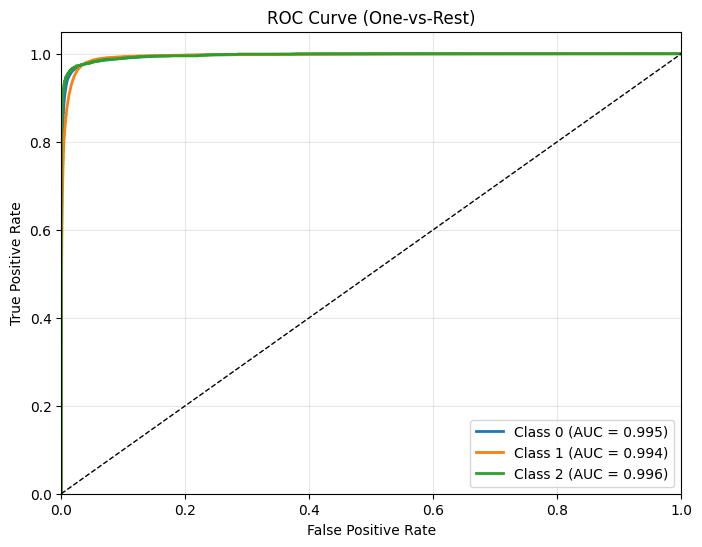

Macro AUC: 0.995406429747324
Weighted AUC: 0.9949875242424773


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# --- Οπτικοποίηση: Καμπύλες ROC (One-vs-Rest) ---

# 1. Συλλογή προβλέψεων (πιθανοτήτων) από το test set
model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        # Εφαρμογή softmax για λήψη πιθανοτήτων
        probs = torch.softmax(outputs, dim=1)
        y_true.extend(y_batch.numpy())
        y_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs)

# 2. Binarization (Δυαδικοποίηση) των ετικετών
# Απαραίτητο για τη στρατηγική One-vs-Rest (OvR) σε multi-class
classes = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=classes)

# 3. Υπολογισμός ROC/AUC και σχεδίαση για κάθε κλάση
plt.figure(figsize=(8,6))
for i, c in enumerate(classes):
    # Υπολογισμός FPR, TPR για την κλάση 'i' έναντι όλων των άλλων
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Κλάση {c} (AUC = {roc_auc:.3f})")

# Σχεδίαση γραμμής τυχαίας πρόβλεψης
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Καμπύλη ROC (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 4. Υπολογισμός συνολικών μετρικών AUC (Macro & Weighted)
print("Macro AUC:", roc_auc_score(y_true_bin, y_probs, average="macro"))
print("Weighted AUC:", roc_auc_score(y_true_bin, y_probs, average="weighted"))